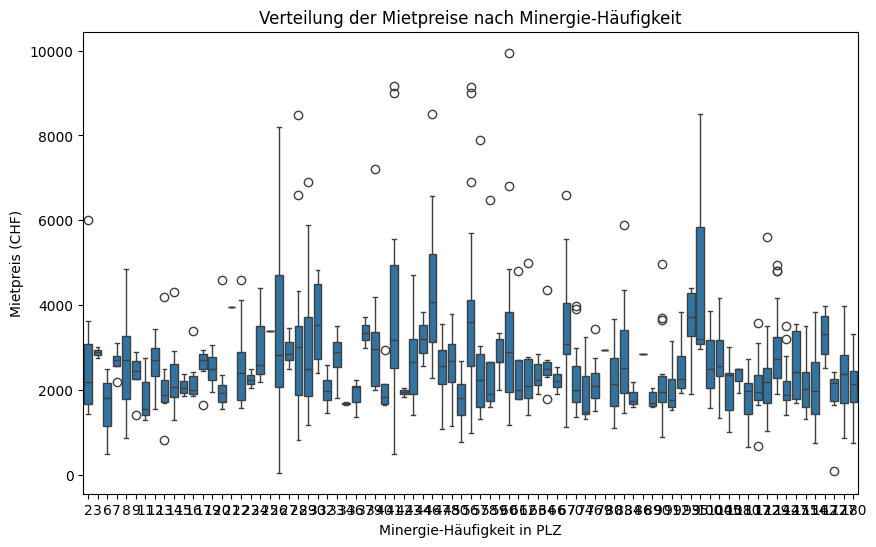

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x=merged_df["Häufigkeit"], y=merged_df["price"])
plt.xlabel("Minergie-Häufigkeit in PLZ")
plt.ylabel("Mietpreis (CHF)")
plt.title("Verteilung der Mietpreise nach Minergie-Häufigkeit")
plt.show()


In [22]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
import gradio as gr

# 🔹 Dateipfade definieren
minergie_data_path = "minergie.csv"
apartment_data_path = "original_apartment_data_analytics_hs24_with_lat_lon.csv"
output_path = "precomputed_data.csv"

# 🔹 Daten laden
minergie_data = pd.read_csv(minergie_data_path)
apartments = pd.read_csv(apartment_data_path)

# Daten zusammenführen
apartments.rename(columns={"postalcode": "PLZ"}, inplace=True)
merged_df = apartments.merge(minergie_data, on="PLZ", how="left")
merged_df["Häufigkeit"].fillna(0, inplace=True)

# Liste aller verfügbaren Orte für das Dropdown-Menü
town_list = sorted(merged_df["town"].unique())

# Feature Engineering
features = ["rooms", "area", "PLZ", "Häufigkeit", "tax_income", "pop_dens", "frg_pct", "emp"]
target = "price"

# Train/Test-Split
X_train, X_test, y_train, y_test = train_test_split(merged_df[features], merged_df[target], test_size=0.2, random_state=42)

# Preprocessing Pipeline
numerical_features = ["rooms", "area", "Häufigkeit", "tax_income", "pop_dens", "frg_pct", "emp"]
categorical_features = ["PLZ"]

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Modell trainieren
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

model.fit(X_train, y_train)

# Modellbewertung
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Modellbewertung:\nR² Score: {r2:.4f}\nRMSE: {rmse:.2f} CHF")

# Modell speichern
with open("price_prediction_model.pkl", "wb") as f:
    pickle.dump(model, f)

# Gradio App

def predict_price(rooms, area, town):
    plz_data = merged_df.loc[merged_df["town"] == town, ["PLZ", "Häufigkeit", "tax_income", "pop_dens", "frg_pct", "emp"]]
    if len(plz_data) == 0:
        return "Fehler: Ort nicht gefunden. Bitte eine gültige Stadt eingeben."
    plz, minergie_freq, tax_income, pop_dens, frg_pct, emp = plz_data.iloc[0]
    input_data = pd.DataFrame([[rooms, area, plz, minergie_freq, tax_income, pop_dens, frg_pct, emp]], columns=features)
    prediction = model.predict(input_data)[0]
    return f"Geschätzter Preis: {round(prediction, 2)} CHF"

iface = gr.Interface(
    fn=predict_price,
    inputs=[
        gr.Number(label="Zimmer"),
        gr.Number(label="Fläche (m²)"),
        gr.Dropdown(choices=town_list, label="Ort")
    ],
    outputs="text",
    title="Wohnungspreis Vorhersage",
   description="Willkommen zur Wohnungspreis-Vorhersage!\n\nDiese App nutzt Machine Learning, um Mietpreise von Wohnungen basierend auf verschiedenen Faktoren vorherzusagen.\n\nWie funktioniert das Modell?\n- Es analysiert Merkmale wie Zimmeranzahl, Wohnfläche, Standort (PLZ) sowie wirtschaftliche und ökologische Faktoren.\n- Die Minergie-Häufigkeit, das durchschnittliche steuerbare Einkommen, die Bevölkerungsdichte, der Ausländeranteil und die Beschäftigungsrate fließen ebenfalls in die Berechnung ein.\n- Das Modell basiert auf einem Random Forest Regressor, das aus vielen Entscheidungsbäumen besteht, um möglichst genaue Vorhersagen zu liefern.\n\nDie Daten zur Minergie-Häufigkeit wurden mithilfe von Web Scraping gesammelt, wobei insgesamt 800 Seiten mit jeweils 12 Gebäuden extrahiert wurden. Jedes dieser Gebäude enthält eine Postleitzahl zur genauen Zuordnung. Die Daten wurden von folgender Seite extrahiert:\nhttps://www.minergie.ch/de/gebaeude/gebaeudeliste/?canton=zh&country=&zip_place=&street_nr=&gid=&typeofuse=&constructiontype=&year=&sortby=year_desc&numres=12&p=50\n\nGebe einfach die Anzahl der Zimmer, die Wohnfläche und den Standort an – und erhalte eine präzise Mietpreisschätzung!",
)

# App starten
if __name__ == "__main__":
    iface.launch()


/tmp/ipykernel_23191/3040592198.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df["Häufigkeit"].fillna(0, inplace=True)


Modellbewertung:
R² Score: 0.5504
RMSE: 864.79 CHF
* Running on local URL:  http://127.0.0.1:7872

To create a public link, set `share=True` in `launch()`.
